# Distributed DataFrames

In [2]:
%matplotlib inline

import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt

/apps/gent/CO7/haswell-ib/software/Python/3.5.2-intel-2016b/lib/python3.5/site-packages/setuptools-23.1.0-py3.5.egg/pkg_resources/__init__.py:1268: UserWarning: /user/home/gent/vsc404/vsc40498/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).


## NYC Taxi data
In this notebook we use distributed dataframes to analyze NYC Taxi data (https://data.cityofnewyork.us/view/ba8s-jw6u)

This data is stored as large CSV files on S3 in a public bucket (https://s3.amazonaws.com/nyc-tlc/trip+data/). We could load them using the `s3fs` library:

    >>> from s3fs import S3FileSystem
    >>> s3 = S3FileSystem(anon=True)

    >>> s3.ls('nyc-tlc/trip data/')
    [...
     'nyc-tlc/trip data/yellow_tripdata_2009-01.csv',
     ...
     'nyc-tlc/trip data/yellow_tripdata_2015-01.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-02.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-03.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-04.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-05.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-06.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-07.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-08.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-09.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-10.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-11.csv',
     'nyc-tlc/trip data/yellow_tripdata_2015-12.csv',
     'nyc-tlc/trip data/yellow_tripdata_2016-01.csv',
     'nyc-tlc/trip data/yellow_tripdata_2016-02.csv',
     'nyc-tlc/trip data/yellow_tripdata_2016-03.csv',
     'nyc-tlc/trip data/yellow_tripdata_2016-04.csv',
     'nyc-tlc/trip data/yellow_tripdata_2016-05.csv',
     'nyc-tlc/trip data/yellow_tripdata_2016-06.csv']
    

To work with these, we did download some of them and put them on a data share. You can copy them to ``$VSC_SCRATCH_NODE`` (`/local`).

We would like to load this data with Pandas, but there is too much data here to fit in memory.

In [3]:
pd.read_csv("/local/yellow_tripdata_2015-01.csv", nrows=5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0,0.3,16.30


Instead, we connect to the cluster and use dask.dataframe to load the CSV data into ~700 Pandas dataframes spread across our cluster.  We get back a Dask.dataframe to coordinate these small Pandas dataframes.

## Setting up a cluster

A `dask.distributed` network consists of one `Scheduler` node and several `Worker` nodes. You connect to these with a `Client`. One can set these up in a variety of ways (https://distributed.readthedocs.io/en/latest/setup.html).

If you create an client without providing an address it will start up a local scheduler and worker for you:

    >>> from distributed import Client
    >>> client = Client()
    >>> client
    <Client: scheduler="127.0.0.1:8786" processes=8 cores=8>
    
You can also set up a network on the HPC cluster, and connect to it using the Scheduler's address:

    >>> client = Client("10.141.18.78:8786")

In [4]:
from distributed import Client, progress

In [5]:
client = Client()

In [6]:
client

<Client: scheduler="127.0.0.1:8786" processes=24 cores=24>

In [7]:
df = dd.read_csv("/local/yellow_tripdata_2015-01.csv",
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [28]:

df = dd.read_csv("/user/data/gent/vsc404/vsc40498/data/NYCtaxi/yellow_tripdata_2015-01.csv",
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [29]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


## Web interface

Information about the current state of the network helps to track progress, identify performance issues, and debug failures.

Dask.distributed includes a web interface to help deliver this information over a normal web page in real time. This web interface is launched by default wherever the scheduler is launched if the scheduler machine has Bokeh installed. The web interface is normally available at http://scheduler-address:8787/status/ and can be viewed any normal web browser.

Connect over ssh to the 8787 port on the node you are working on, and see the web interface on: http://127.0.0.1:8787/status/

In [30]:
df = client.persist(df)
progress(df)

In [31]:
len(df)

12748986

In [32]:
df.passenger_count.sum().compute()

21437303

In [33]:
df

dd.DataFrame<from-de..., npartitions=32>

In [34]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [35]:
df.info(memory_usage=True)

<class 'dask.dataframe.core.DataFrame'>
Data columns (total 19 columns):
VendorID                   int64
tpep_pickup_datetime       datetime64[ns]
tpep_dropoff_datetime      datetime64[ns]
passenger_count            int64
trip_distance              float64
pickup_longitude           float64
pickup_latitude            float64
RateCodeID                 int64
store_and_fwd_flag         object
dropoff_longitude          float64
dropoff_latitude           float64
payment_type               int64
fare_amount                float64
extra                      float64
mta_tax                    float64
tip_amount                 float64
tolls_amount               float64
improvement_surcharge      float64
total_amount               float64
dtypes: datetime64[ns](2), object(1), float64(12), int64(4)
memory usage: 1.8 GB


### Play

Existing Pandas experience transfers over decently well to Dask.dataframe.  However there are a few caveats when dealing with distributed systems:

*  Until you call `client.persist` (for large results) or `client.compute` (for small results), all computations are lazy
*  Call `progress` on a dataframe *after* you persist to track the progress of a computation.  You can continue doing work immediately.  All work happens in the background.
*  If you are computing a small result, just add `.compute()` to the end of your result, like `df.passenger_count.sum().compute()`.  This will block and return the result when finished.

### Example

In [14]:
positive_fares = df[df.fare_amount > 0]
fares = df[['fare_amount', 'tip_amount', 'payment_type']]

fares = client.persist(fares)  # triggers computation
progress(fares)

In [15]:
fares.head()

,fare_amount,tip_amount,payment_type
0,12.0,3.25,1
1,14.5,2.00,1
2,9.5,0.00,2
3,3.5,0.00,2
4,15.0,0.00,2


In [52]:
(fares.tip_amount == 0).sum().compute()

20296808

In [53]:
fares.count().compute()

fare_amount     51622905
tip_amount      51622905
payment_type    51622905
dtype: int64

In [54]:
df.passenger_count.sum().compute()

86448671

<div class="alert alert-success">
    <b>EXERCISE</b>: 
    
Compute the following using `.compute()`:

<ul>
<li>The mean of the passenger count column</li>
<li>The mean trip distance grouped by passenger count</li>
</ul>

<p>Create a new dataframe that filters out all the rides greater than three miles, then compute the above quantities again.  </p>
</div>

In [17]:
df.passenger_count.mean().compute()

1.6814908260154964

In [19]:
df.groupby('passenger_count').trip_distance.mean().compute()

passenger_count
0     2.162647
1    14.826122
2    18.040789
3     2.852763
4     2.871686
5     2.856184
6     2.788518
7     2.566667
8     2.179000
9     7.269091
Name: trip_distance, dtype: float64

In [22]:
df2 = df[df.trip_distance > 3]
df2.passenger_count.mean().compute()
df2.groupby('passenger_count').trip_distance.mean().compute()

passenger_count
0     6.124779
1    56.467714
2    64.102374
3     6.953295
4     6.947401
5     6.972930
6     6.906075
7     6.233333
8    10.295000
9    15.962000
Name: trip_distance, dtype: float64

## Setting the time as index

Use the `.set_index` method to set the index to the `tpep_pickup_datetime` column.  This is an *expensive* operation, so call `client.persist` on the result to create a new dataframe that is persisted in distributed memory.  Use the `progress` function to track the progress.

Once this finishes you have access to datetime functionality like `loc`, `resample` and `rolling` aggregations.  

In [24]:
df2 = df.set_index('tpep_pickup_datetime')

In [25]:
df2 = client.persist(df2)
progress(df2)

The dask dataframe now has divisions, making certain operations much more efficient.

In [26]:
df.divisions

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [27]:
df2.divisions

(Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-02 09:20:34'),
 Timestamp('2015-01-02 20:54:28'),
 Timestamp('2015-01-04 01:49:30'),
 Timestamp('2015-01-05 15:20:51'),
 Timestamp('2015-01-05 21:09:12.533333504'),
 Timestamp('2015-01-06 20:09:28'),
 Timestamp('2015-01-08 20:29:20'),
 Timestamp('2015-01-09 03:34:11'),
 Timestamp('2015-01-09 13:34:52'),
 Timestamp('2015-01-10 11:06:53.030284032'),
 Timestamp('2015-01-11 22:00:36.914896128'),
 Timestamp('2015-01-13 11:37:05.050705152'),
 Timestamp('2015-01-13 21:23:08.450108416'),
 Timestamp('2015-01-14 08:58:10.583333376'),
 Timestamp('2015-01-15 00:55:56'),
 Timestamp('2015-01-16 14:22:29'),
 Timestamp('2015-01-17 02:38:04.418909184'),
 Timestamp('2015-01-18 13:38:37.399789568'),
 Timestamp('2015-01-18 18:39:53'),
 Timestamp('2015-01-19 11:49:03'),
 Timestamp('2015-01-20 13:42:12'),
 Timestamp('2015-01-22 09:49:00'),
 Timestamp('2015-01-23 13:16:51.945712640'),
 Timestamp('2015-01-23 18:27:13'),
 Timestamp('2015-01-24 02:05:41'),


<div class="alert alert-success">
    <b>EXERCISE</b>: Plot the hourly number of taxi trips for Jan 1 to Jan 5
</div>

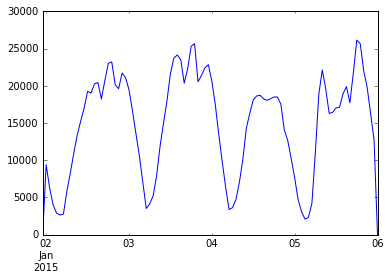

In [64]:
df2['2015-01-01':'2015-01-06'].trip_distance.resample('H').count().compute().plot()

<div class="alert alert-success">
    <b>EXERCISE</b>: Plot daily profile of number of taxi trips
</div>

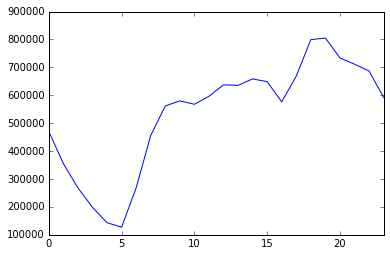

In [70]:
df2.groupby(df2.index.hour).size().compute().plot()

<div class="alert alert-success">
    <b>EXERCISE</b>: Plot the daily tip average
</div>

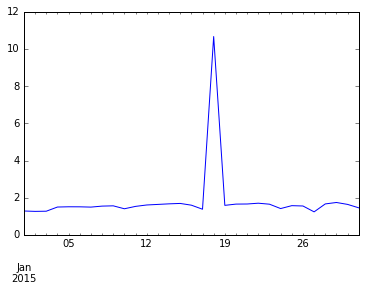

In [49]:
df2.tip_amount.resample('D').mean().compute().plot()

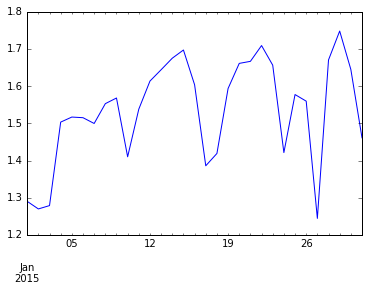

In [48]:
df2.tip_amount.max().compute()
df2[df2.tip_amount < 1000].tip_amount.resample('D').mean().compute().plot()

<div class="alert alert-success">
    <b>EXERCISE</b>: Based on the previous result: Is there a week pattern within the avarage tip amount?
</div>

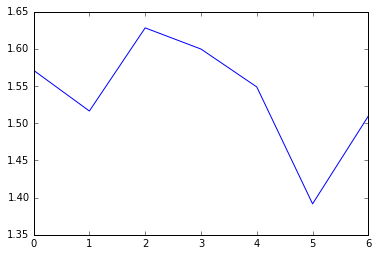

In [58]:
daily = df2[df2.tip_amount < 1000].tip_amount.resample('D').mean()
daily.groupby(daily.index.weekday).mean().compute().plot()

<div class="alert alert-success">
    <b>EXERCISE</b>: For those trips were a tip has been given, calculate the tip fraction (tip_amount / fare_amount) and calculate the daily profile of this fraction.
</div>

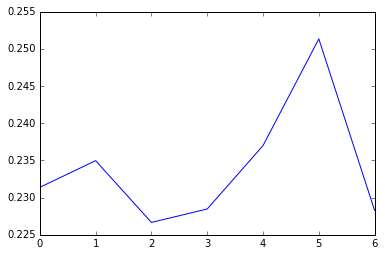

In [80]:
df3 = df2[(df2.tip_amount > 0) & (df2.fare_amount > 0) & (df2.tip_amount < 100)]
df3 = df3.assign(tip_fraction=df3.tip_amount / df3.fare_amount)

dayofweek = df3.groupby(df3.index.dayofweek).tip_fraction.mean()
hour = df3.groupby(df3.index.hour).tip_fraction.mean()

dayofweek.compute().plot()
hour.compute().plot()

## More data

Up to now we performed the analyses on one of the csv files: all data for January 2015. You can repeat the notebook with multiple of the files:  

    df = dd.read_csv("/local/yellow_tripdata_2015-*.csv",
                     parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])